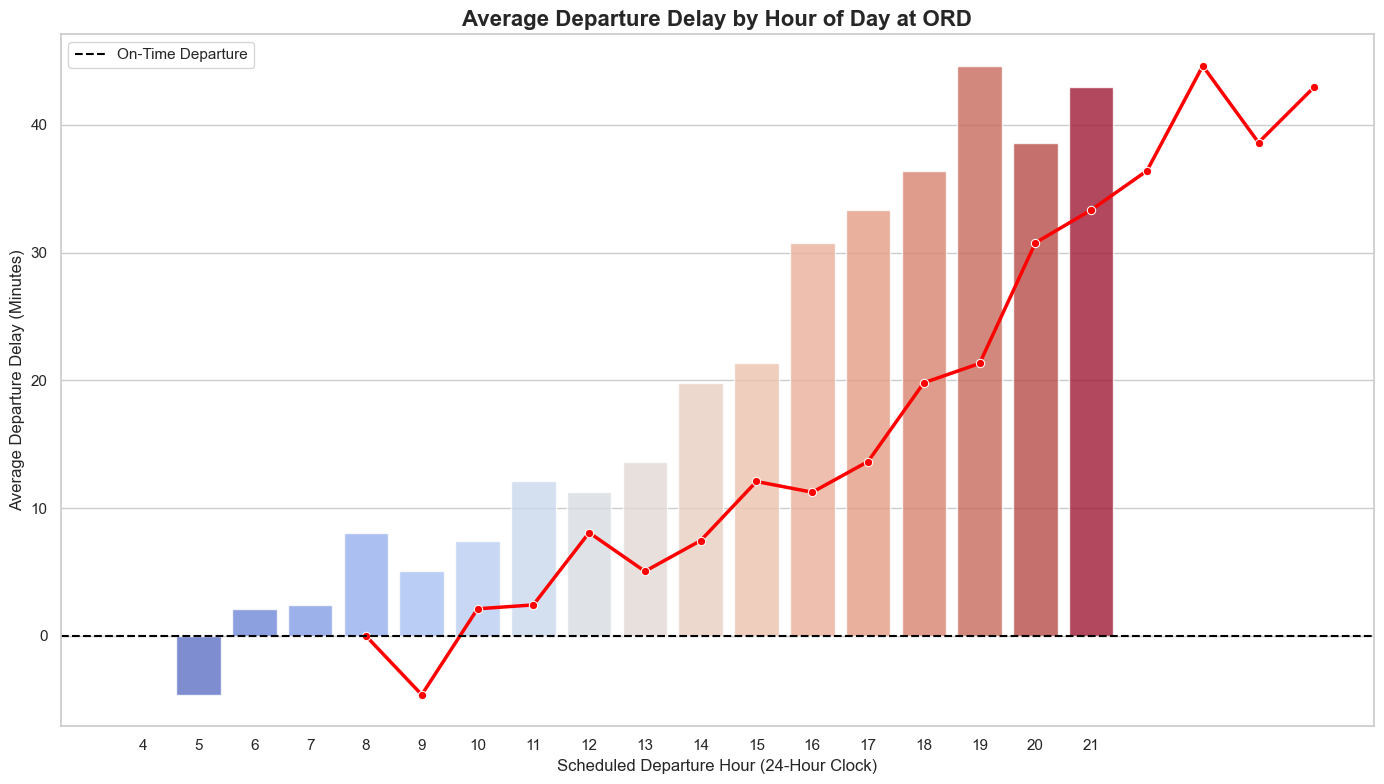

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_data = pd.read_csv('Flight Level Data.csv')

flight_data['scheduled_departure_datetime_local'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'], errors='coerce')
flight_data['actual_departure_datetime_local'] = pd.to_datetime(flight_data['actual_departure_datetime_local'], errors='coerce')

flight_data.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)

flight_data['departure_delay_minutes'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60

flight_data['departure_hour'] = flight_data['scheduled_departure_datetime_local'].dt.hour

avg_delay_by_hour = flight_data.groupby('departure_hour')['departure_delay_minutes'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

ax = sns.barplot(
    data=avg_delay_by_hour,
    x='departure_hour',
    y='departure_delay_minutes',
    palette='coolwarm',
    alpha=0.8,
    hue='departure_hour',
    legend=False
)

sns.lineplot(
    data=avg_delay_by_hour,
    x='departure_hour',
    y='departure_delay_minutes',
    color='red',
    marker='o',
    linewidth=2.5,
    ax=ax
)

plt.title('Average Departure Delay by Hour of Day at ORD', fontsize=16, fontweight='bold')
plt.xlabel('Scheduled Departure Hour (24-Hour Clock)', fontsize=12)
plt.ylabel('Average Departure Delay (Minutes)', fontsize=12)
plt.xticks(rotation=0)
plt.axhline(0, color='black', linestyle='--', linewidth=1.5, label='On-Time Departure')
plt.legend()

plt.tight_layout()
plt.show()

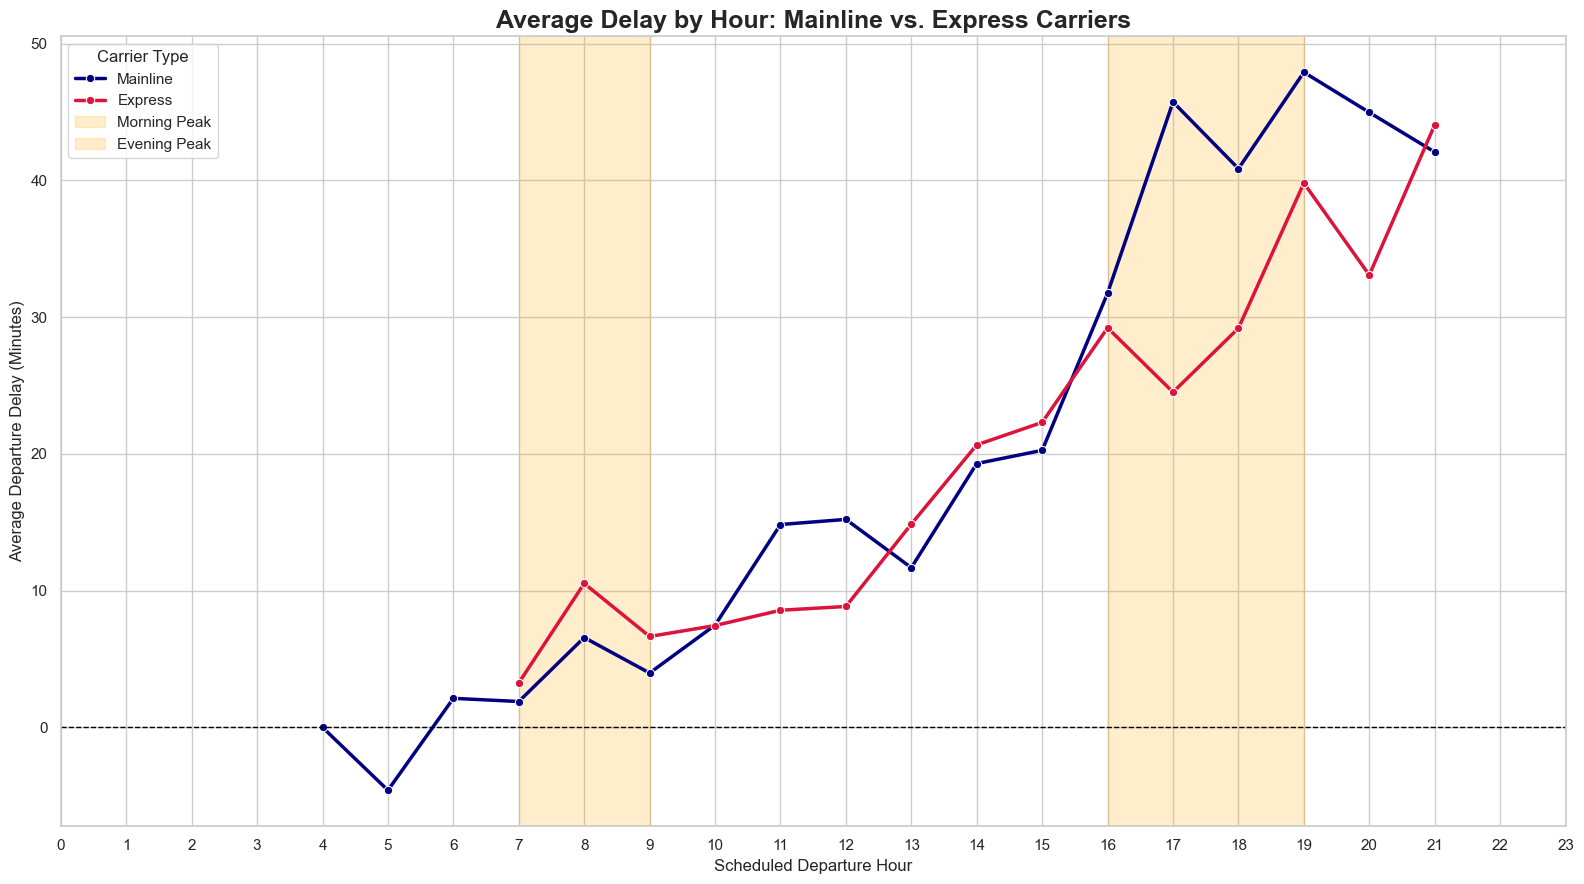

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_data = pd.read_csv('Flight Level Data.csv')

flight_data['scheduled_departure_datetime_local'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'], errors='coerce')
flight_data['actual_departure_datetime_local'] = pd.to_datetime(flight_data['actual_departure_datetime_local'], errors='coerce')
flight_data.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local', 'carrier'], inplace=True)

flight_data['departure_delay_minutes'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60
flight_data['departure_hour'] = flight_data['scheduled_departure_datetime_local'].dt.hour

hourly_carrier_delay = flight_data.groupby(['departure_hour', 'carrier'])['departure_delay_minutes'].mean().reset_index()

plt.figure(figsize=(16, 9))
sns.set_style("whitegrid")

ax = sns.lineplot(
    data=hourly_carrier_delay,
    x='departure_hour',
    y='departure_delay_minutes',
    hue='carrier',
    marker='o',
    linewidth=2.5,
    palette={'Mainline': 'navy', 'Express': 'crimson'}
)

ax.axvspan(7, 9, color='orange', alpha=0.2, label='Morning Peak')
ax.axvspan(16, 19, color='orange', alpha=0.2, label='Evening Peak')

ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_title('Average Delay by Hour: Mainline vs. Express Carriers', fontsize=18, fontweight='bold')
ax.set_xlabel('Scheduled Departure Hour', fontsize=12)
ax.set_ylabel('Average Departure Delay (Minutes)', fontsize=12)
ax.set_xticks(range(0, 24, 1))
ax.legend(title='Carrier Type')
plt.tight_layout()
plt.show()


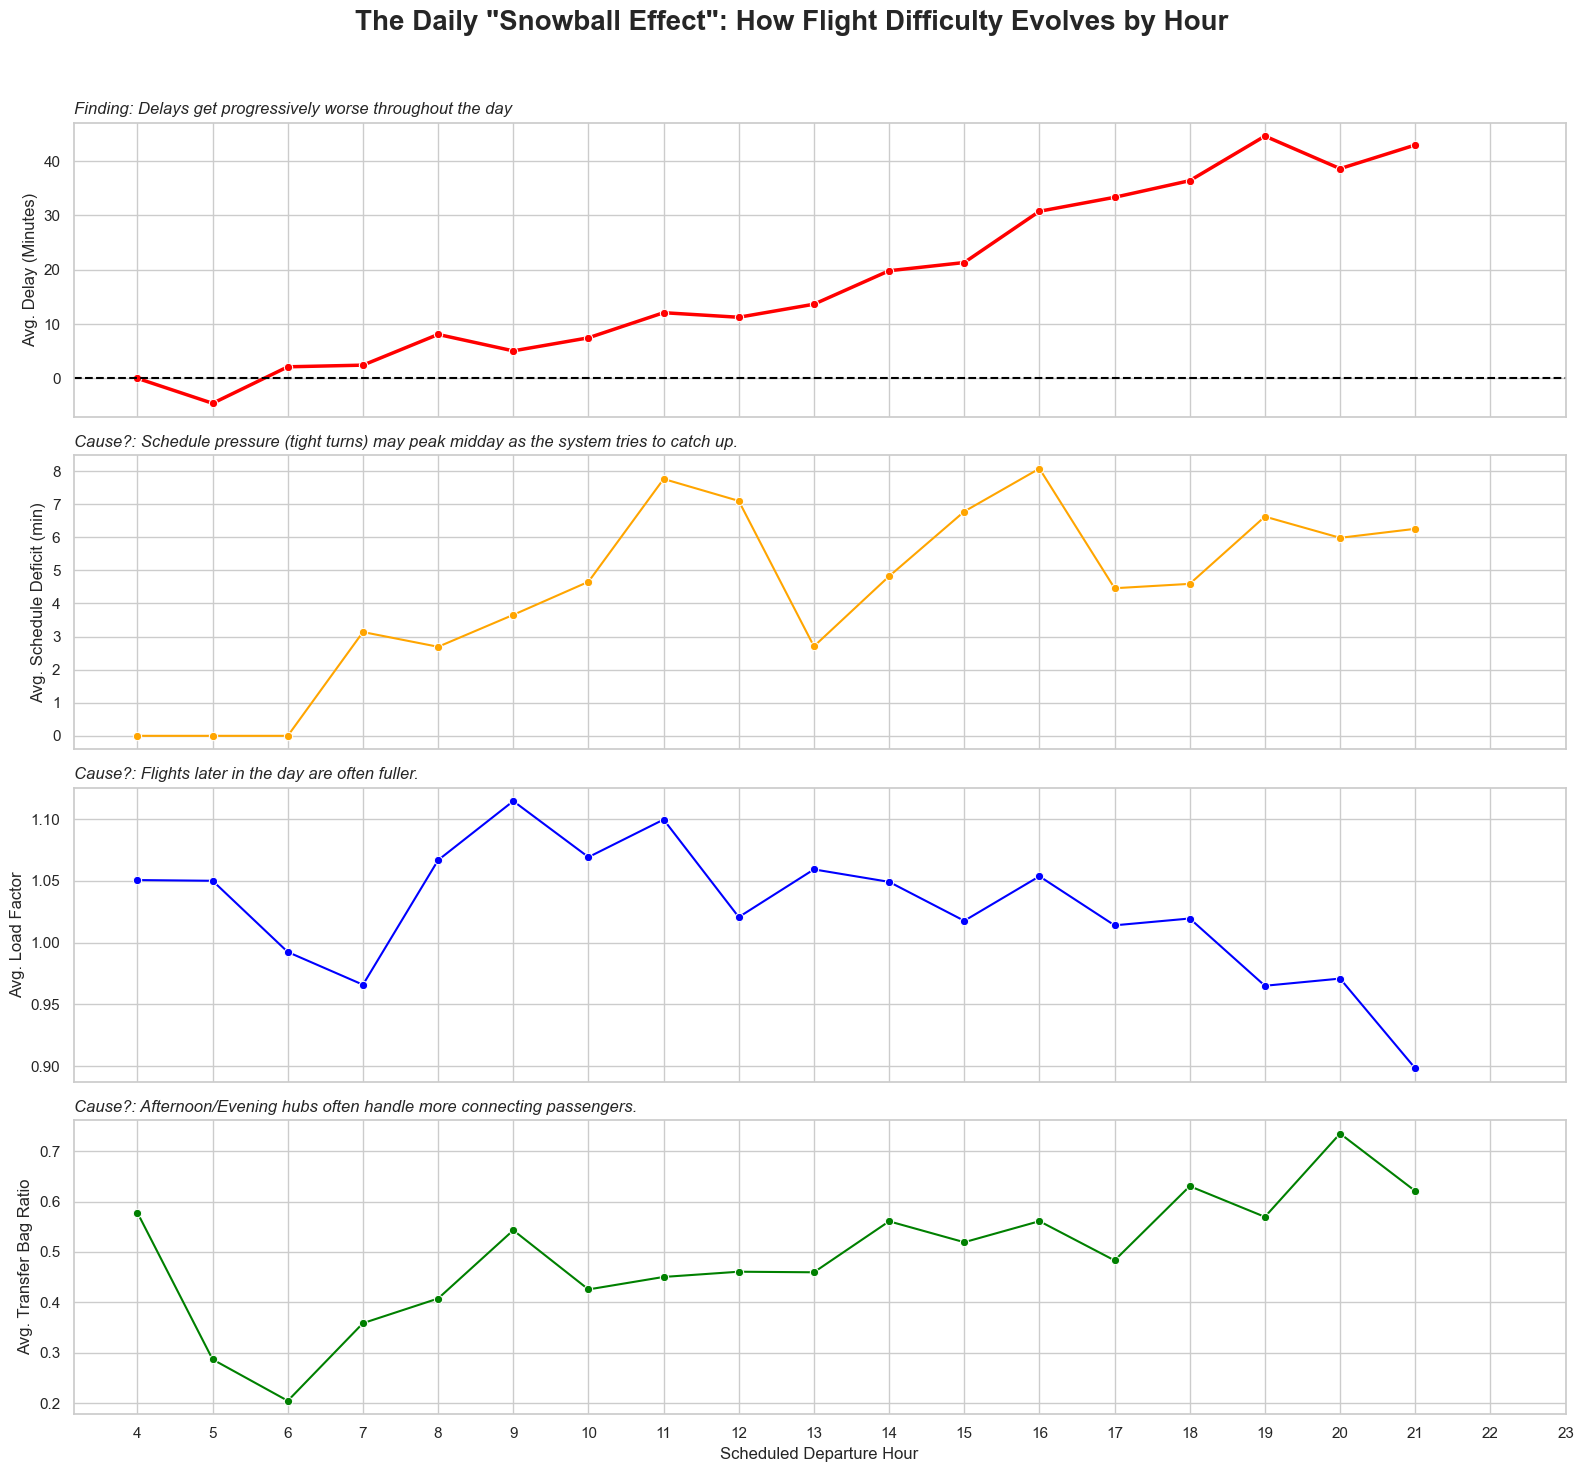

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

flight_data = pd.read_csv('Flight Level Data.csv')
pnr_flight_data = pd.read_csv('PNR Flight Level Data.csv')
pnr_remarks_data = pd.read_csv('PNR Remark Level Data.csv')
bag_data = pd.read_csv('Bag Level Data.csv')

def create_flight_key(df):
    date_col = 'scheduled_departure_date_local'
    df[date_col] = pd.to_datetime(df[date_col]).dt.date
    return (df[date_col].astype(str) + '_' +
            df['flight_number'].astype(str) + '_' +
            df['scheduled_departure_station_code'].astype(str))

for df in [flight_data, pnr_flight_data, bag_data]:
    df['flight_key'] = create_flight_key(df)

flight_data['scheduled_departure_datetime_local'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'], errors='coerce')
flight_data['actual_departure_datetime_local'] = pd.to_datetime(flight_data['actual_departure_datetime_local'], errors='coerce')
flight_data.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)
flight_data['departure_delay'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60
flight_data['departure_hour'] = flight_data['scheduled_departure_datetime_local'].dt.hour
flight_data['ground_time_pressure'] = (flight_data['minimum_turn_minutes'] - flight_data['scheduled_ground_time_minutes']).clip(lower=0)

pax_counts = pnr_flight_data.groupby('flight_key')['total_pax'].sum().reset_index()
analysis_df = pd.merge(flight_data, pax_counts, on='flight_key', how='left')
analysis_df['load_factor'] = analysis_df['total_pax'] / analysis_df['total_seats']

bag_counts = bag_data.groupby('flight_key').size().reset_index(name='total_bags')
transfer_bags = bag_data[bag_data['bag_type'] == 'Transfer'].groupby('flight_key').size().reset_index(name='transfer_bags')
bag_analysis = pd.merge(bag_counts, transfer_bags, on='flight_key', how='left')
bag_analysis['transfer_ratio'] = (bag_analysis['transfer_bags'] / bag_analysis['total_bags']).fillna(0)
analysis_df = pd.merge(analysis_df, bag_analysis, on='flight_key', how='left')
analysis_df.fillna(0, inplace=True)

hourly_summary = analysis_df.groupby('departure_hour').agg(
    Average_Delay=('departure_delay', 'mean'),
    Avg_Ground_Time_Pressure=('ground_time_pressure', 'mean'),
    Average_Load_Factor=('load_factor', 'mean'),
    Avg_Transfer_Ratio=('transfer_ratio', 'mean')
).reset_index()

hourly_summary = hourly_summary[hourly_summary['departure_hour'] >= 4]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 15), sharex=True)
fig.suptitle('The Daily "Snowball Effect": How Flight Difficulty Evolves by Hour', fontsize=20, fontweight='bold')
sns.set_theme(style="whitegrid")

sns.lineplot(data=hourly_summary, x='departure_hour', y='Average_Delay', ax=axes[0], color='red', marker='o', linewidth=2.5)
axes[0].set_ylabel('Avg. Delay (Minutes)')
axes[0].axhline(0, ls='--', color='black')
axes[0].set_title('Finding: Delays get progressively worse throughout the day', loc='left', style='italic')

sns.lineplot(data=hourly_summary, x='departure_hour', y='Avg_Ground_Time_Pressure', ax=axes[1], color='orange', marker='o')
axes[1].set_ylabel('Avg. Schedule Deficit (min)')
axes[1].set_title('Cause?: Schedule pressure (tight turns) may peak midday as the system tries to catch up.', loc='left', style='italic')

sns.lineplot(data=hourly_summary, x='departure_hour', y='Average_Load_Factor', ax=axes[2], color='blue', marker='o')
axes[2].set_ylabel('Avg. Load Factor')
axes[2].set_title('Cause?: Flights later in the day are often fuller.', loc='left', style='italic')

sns.lineplot(data=hourly_summary, x='departure_hour', y='Avg_Transfer_Ratio', ax=axes[3], color='green', marker='o')
axes[3].set_ylabel('Avg. Transfer Bag Ratio')
axes[3].set_title('Cause?: Afternoon/Evening hubs often handle more connecting passengers.', loc='left', style='italic')

axes[3].set_xlabel('Scheduled Departure Hour', fontsize=12)
plt.xticks(np.arange(4, 24, 1))
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



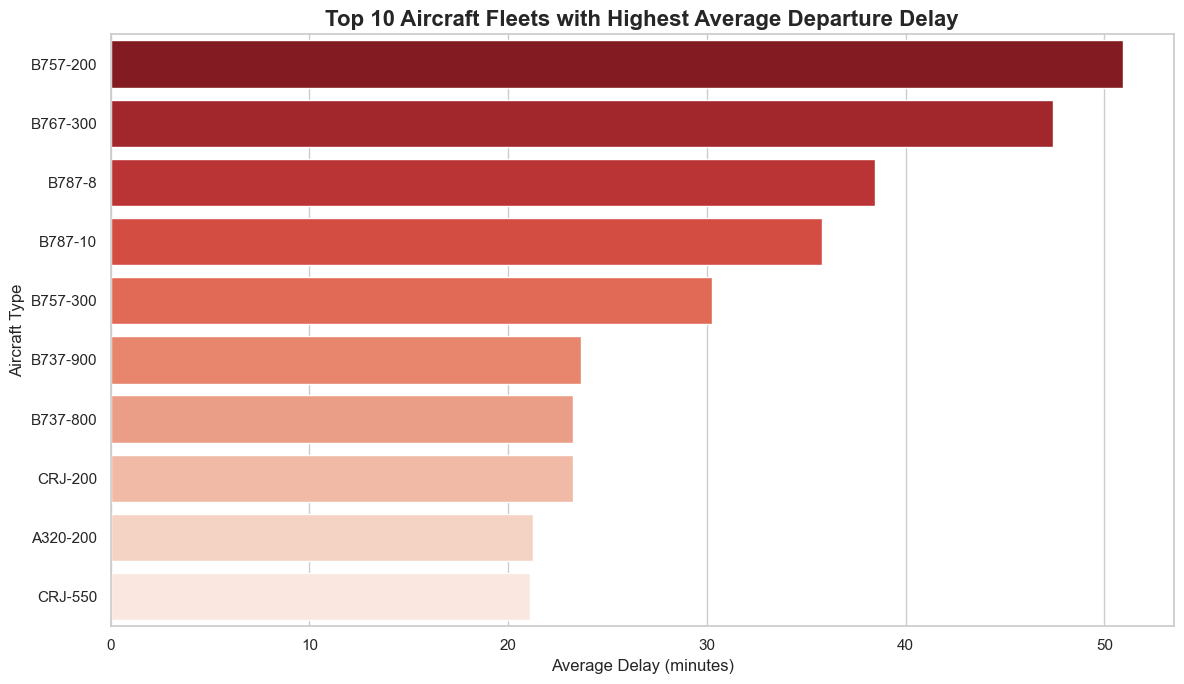

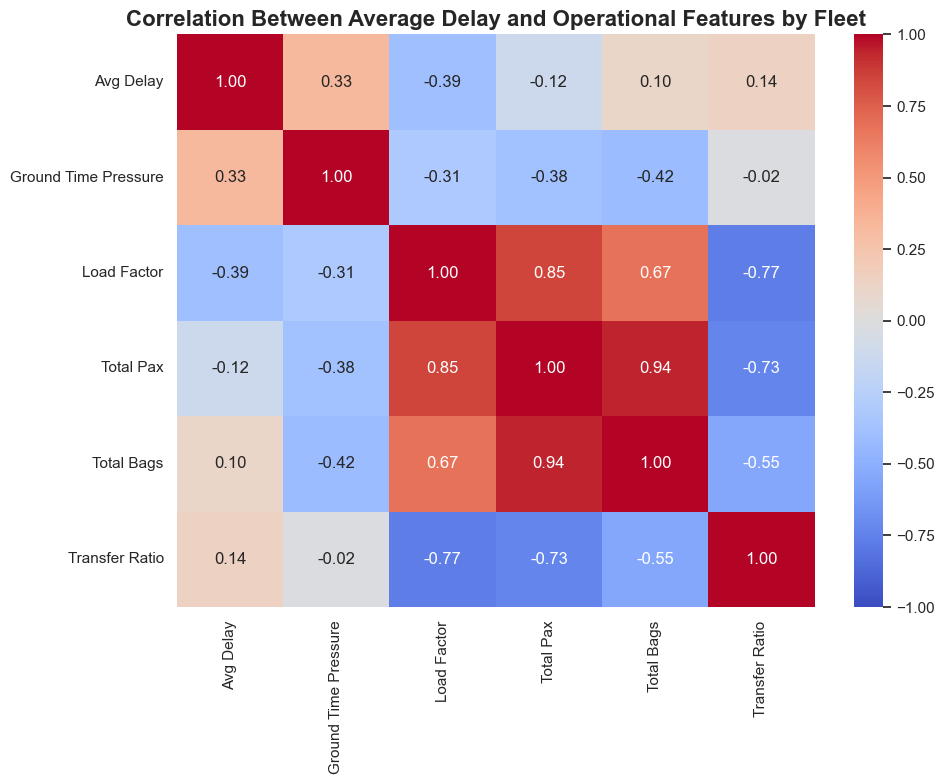

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_data = pd.read_csv('Flight Level Data.csv')
pnr_flight_data = pd.read_csv('PNR Flight Level Data.csv')
bag_data = pd.read_csv('Bag Level Data.csv')

def create_flight_key(df):
    date_col = 'scheduled_departure_date_local'
    df[date_col] = pd.to_datetime(df[date_col]).dt.date
    return (df[date_col].astype(str) + '_' +
            df['flight_number'].astype(str) + '_' +
            df['scheduled_departure_station_code'].astype(str))

for df in [flight_data, pnr_flight_data, bag_data]:
    df['flight_key'] = create_flight_key(df)

flight_data['scheduled_departure_datetime_local'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'], errors='coerce')
flight_data['actual_departure_datetime_local'] = pd.to_datetime(flight_data['actual_departure_datetime_local'], errors='coerce')
flight_data.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)
flight_data['departure_delay'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60
flight_data['ground_time_pressure'] = (flight_data['minimum_turn_minutes'] - flight_data['scheduled_ground_time_minutes']).clip(lower=0)

pax_counts = pnr_flight_data.groupby('flight_key')['total_pax'].sum().reset_index()
bag_counts = bag_data.groupby('flight_key').size().reset_index(name='total_bags')
transfer_bags = bag_data[bag_data['bag_type'] == 'Transfer'].groupby('flight_key').size().reset_index(name='transfer_bags')
bag_analysis = pd.merge(bag_counts, transfer_bags, on='flight_key', how='left').fillna(0)
bag_analysis['transfer_ratio'] = bag_analysis['transfer_bags'] / bag_analysis['total_bags']

analysis_df = pd.merge(flight_data, pax_counts, on='flight_key', how='left')
analysis_df = pd.merge(analysis_df, bag_analysis, on='flight_key', how='left')
analysis_df['load_factor'] = analysis_df['total_pax'] / analysis_df['total_seats']
analysis_df.fillna(0, inplace=True)

delay_summary = analysis_df.groupby('fleet_type')['departure_delay'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)

features = ['ground_time_pressure', 'load_factor', 'total_pax', 'total_bags', 'transfer_ratio']
for f in features:
    delay_summary[f + '_avg'] = analysis_df.groupby('fleet_type')[f].mean()
delay_summary = delay_summary.reset_index()

top10 = delay_summary.head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x='mean', y='fleet_type', data=top10, palette='Reds_r', orient='h', hue='fleet_type', legend=False)
plt.title("Top 10 Aircraft Fleets with Highest Average Departure Delay", fontsize=16, fontweight='bold')
plt.xlabel("Average Delay (minutes)", fontsize=12)
plt.ylabel("Aircraft Type", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
corr_cols = ['mean'] + [f + '_avg' for f in features]
corr_data = delay_summary[corr_cols]
corr_data.columns = ['Avg Delay'] + [f.replace('_', ' ').title() for f in features]
sns.heatmap(corr_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between Average Delay and Operational Features by Fleet", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

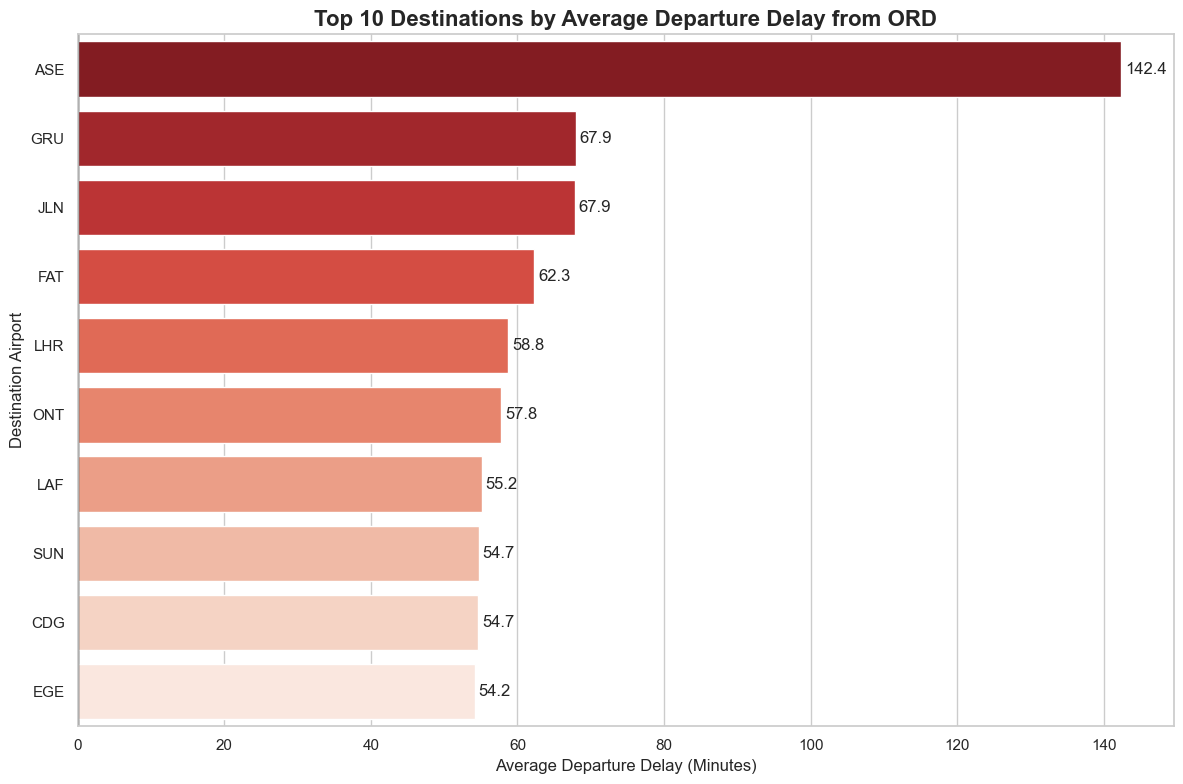

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_data = pd.read_csv('Flight Level Data.csv')

flight_data['scheduled_departure_datetime_local'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'], errors='coerce')
flight_data['actual_departure_datetime_local'] = pd.to_datetime(flight_data['actual_departure_datetime_local'], errors='coerce')
flight_data.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)

flight_data['departure_delay_minutes'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60

avg_delay_by_destination = flight_data.groupby('scheduled_arrival_station_code')['departure_delay_minutes'].mean().reset_index()

sorted_destinations = avg_delay_by_destination.sort_values(by='departure_delay_minutes', ascending=False)

top_10_delayed_destinations = sorted_destinations.head(10)

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

barplot = sns.barplot(
    data=top_10_delayed_destinations,
    x='departure_delay_minutes',
    y='scheduled_arrival_station_code',
    palette='Reds_r',
    hue='scheduled_arrival_station_code',
    legend=False
)

for p in barplot.patches:
    width = p.get_width()
    plt.text(width + 0.5, p.get_y() + p.get_height() / 2,
             f'{width:.1f}',
             ha='left', va='center')

plt.title('Top 10 Destinations by Average Departure Delay from ORD', fontsize=16, fontweight='bold')
plt.xlabel('Average Departure Delay (Minutes)', fontsize=12)
plt.ylabel('Destination Airport', fontsize=12)
plt.axvline(0, color='black', linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()



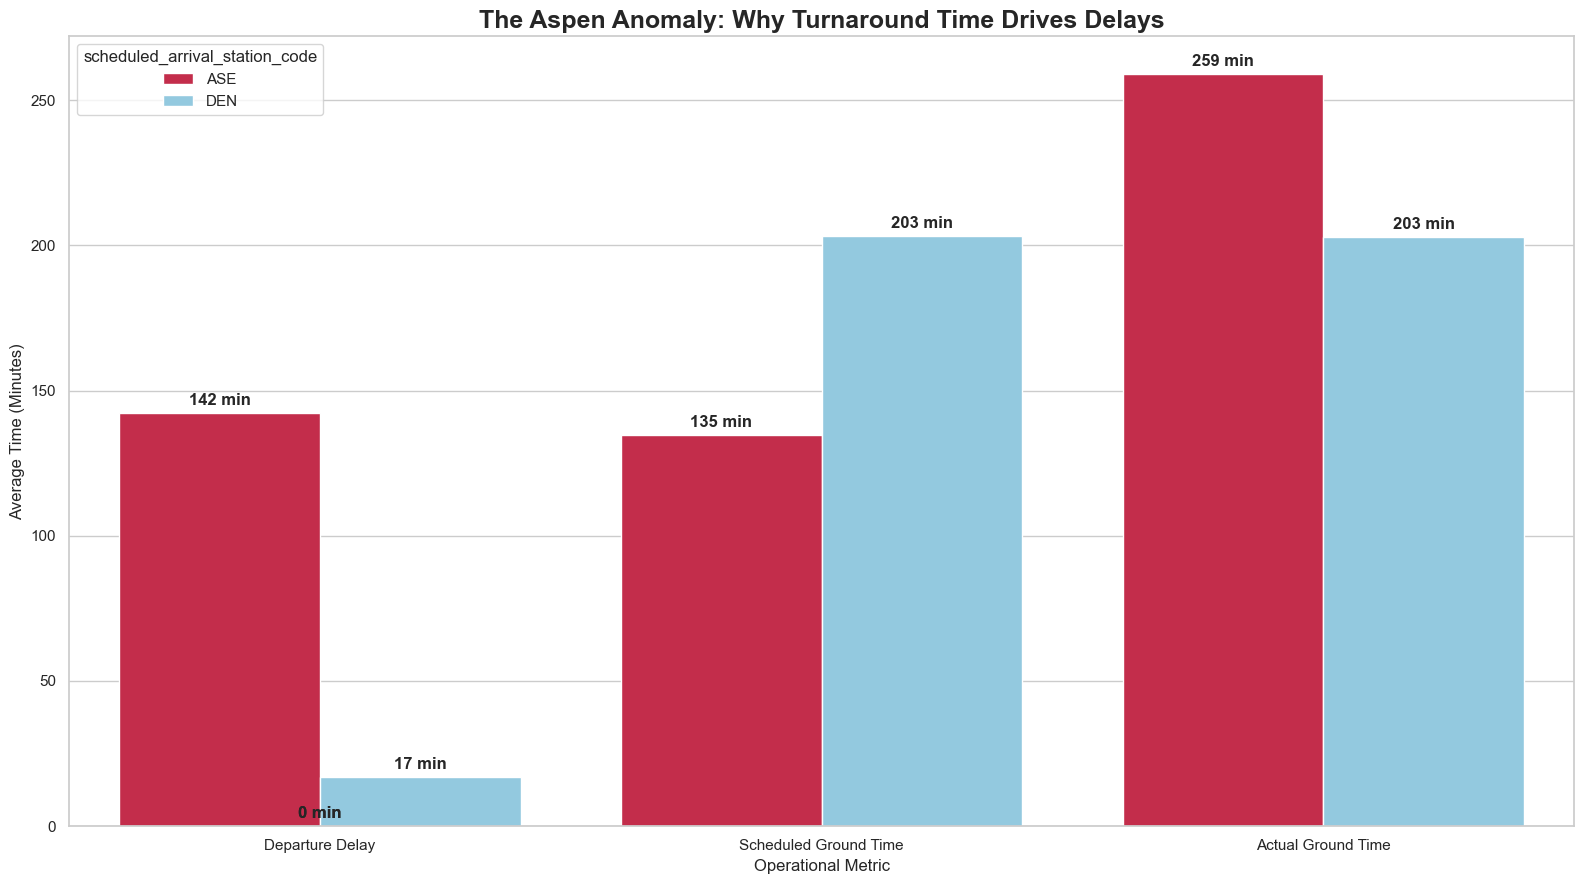

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flight_data = pd.read_csv('Flight Level Data.csv')

flight_data['scheduled_departure_datetime_local'] = pd.to_datetime(flight_data['scheduled_departure_datetime_local'], errors='coerce')
flight_data['actual_departure_datetime_local'] = pd.to_datetime(flight_data['actual_departure_datetime_local'], errors='coerce')
flight_data.dropna(subset=['scheduled_departure_datetime_local', 'actual_departure_datetime_local'], inplace=True)
flight_data['departure_delay'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60

comparison_df = flight_data[flight_data['scheduled_arrival_station_code'].isin(['ASE', 'DEN'])].copy()
comparison_df.dropna(subset=['actual_ground_time_minutes', 'scheduled_ground_time_minutes'], inplace=True)

summary = comparison_df.groupby('scheduled_arrival_station_code').agg(
    Avg_Delay=('departure_delay', 'mean'),
    Avg_Scheduled_Ground_Time=('scheduled_ground_time_minutes', 'mean'),
    Avg_Actual_Ground_Time=('actual_ground_time_minutes', 'mean')
).reset_index()

plot_data = pd.melt(summary, id_vars='scheduled_arrival_station_code', var_name='Metric', value_name='Average Minutes')

plt.figure(figsize=(16, 9))
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=plot_data,
    x='Metric',
    y='Average Minutes',
    hue='scheduled_arrival_station_code',
    palette={'ASE': 'crimson', 'DEN': 'skyblue'}
)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f} min',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontweight='bold')

plt.title('The Aspen Anomaly: Why Turnaround Time Drives Delays', fontsize=18, fontweight='bold')
plt.xlabel('Operational Metric', fontsize=12)
plt.ylabel('Average Time (Minutes)', fontsize=12)
plt.xticks(ticks=[0,1,2], labels=['Departure Delay', 'Scheduled Ground Time', 'Actual Ground Time'], rotation=0)
plt.tight_layout()
plt.show()
